# Distribution checking
This notebook explores similiarity in distributions between test and training datasets, both by year and across all training years. Findings:
* in most cases, large ks-statistic indicates test distribution differs from by year training distribution
* columns related to building itself (state factor, building class, facility type, floor area) indicate years 1 and 2 are most different from test distribution
* for weather/environmental related columns, the top different years vary

In [221]:
%load_ext nb_black
import sys

from scipy import stats

wids_path = "/Users/diana/Documents/projects/widsdatathon2022"
sys.path.append(wids_path)

from global_vars import all_feature_columns, response_column
import utils.model_utils as mu
from utils.data_utils import *
from utils.visualize import *
from utils.data_process_utils import *

pd.set_option("display.max_columns", 500)
sns.set_context("talk")

#### read in data
test_df = pd.read_csv(f"{wids_path}/data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv(f"{wids_path}/data/train.csv")
print(f"Train dimension: {train_df.shape}")
sample_solution_df = pd.read_csv(f"{wids_path}/data/sample_solution.csv")
print(f"Sample solution dimension: {sample_solution_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
Test dimension: (9705, 63)
Train dimension: (75757, 64)
Sample solution dimension: (9705, 2)


<IPython.core.display.Javascript object>

In [222]:
train_df["log10_floor_area"] = np.log10(train_df["floor_area"])
test_df["log10_floor_area"] = np.log10(test_df["floor_area"])
train_df = parse_facility_type(train_df)
test_df = parse_facility_type(test_df)
all_df = (
    pd.concat([train_df, test_df]).astype({"year_factor": str}).reset_index(drop=True)
)
all_df.columns

Index(['year_factor', 'state_factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'elevation',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

<IPython.core.display.Javascript object>

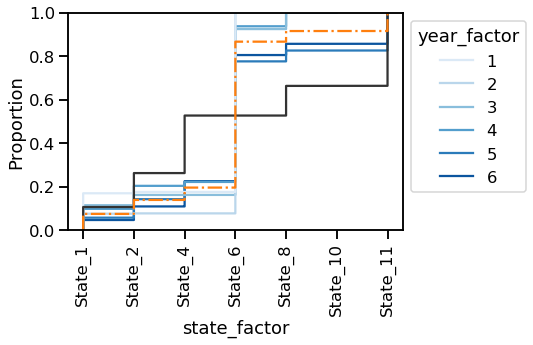

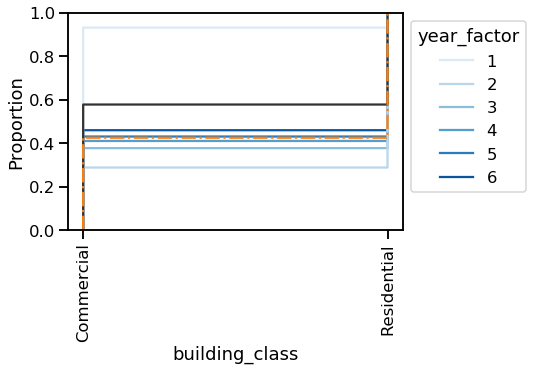

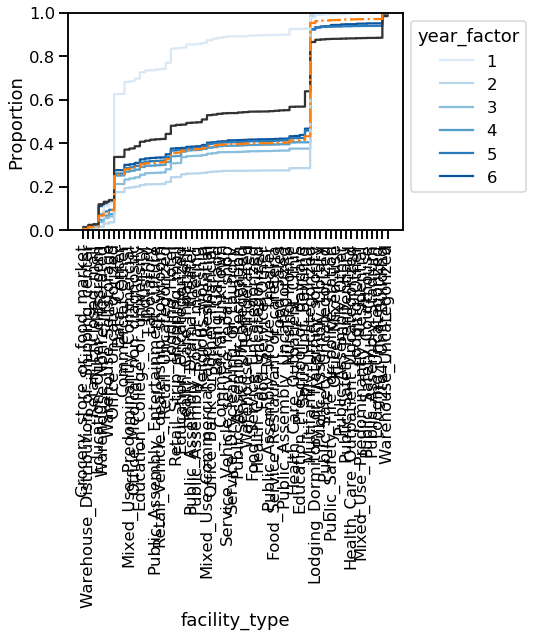

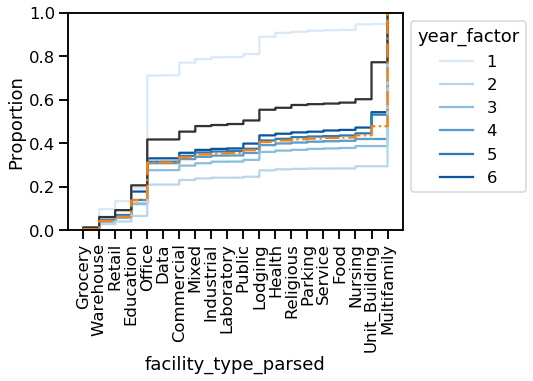

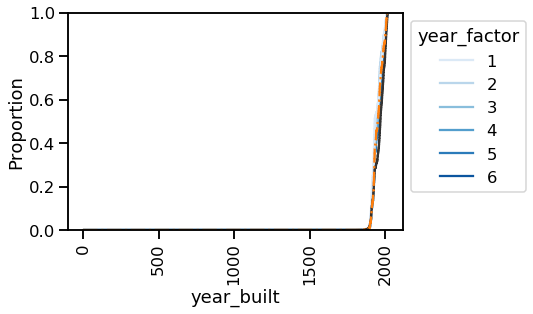

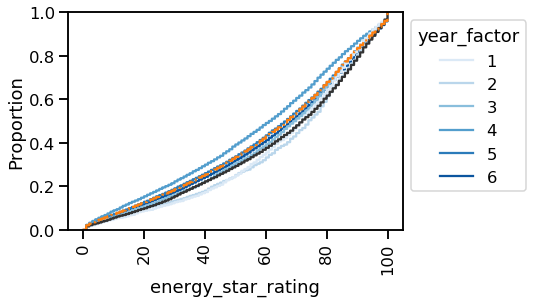

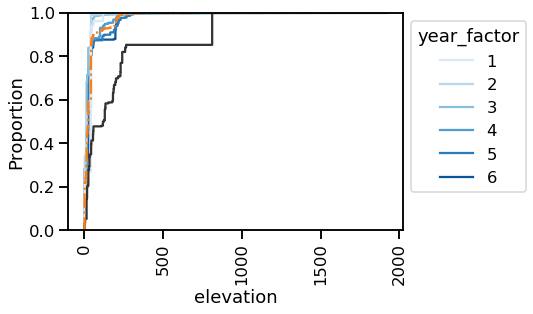

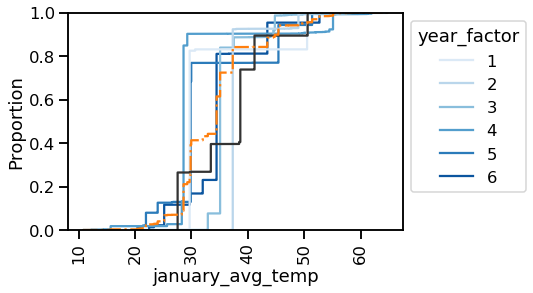

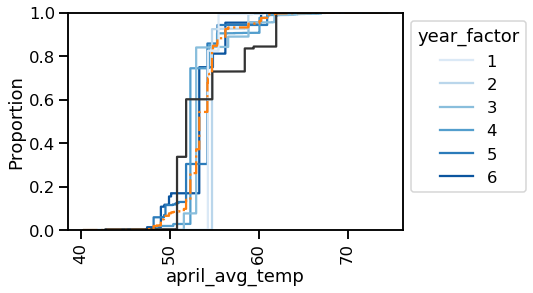

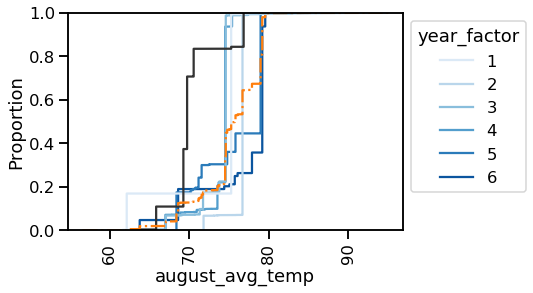

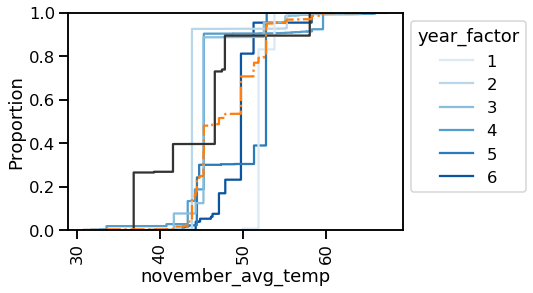

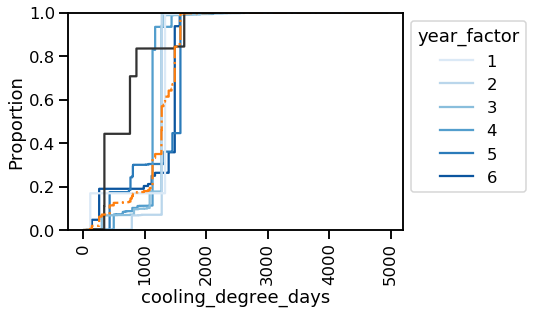

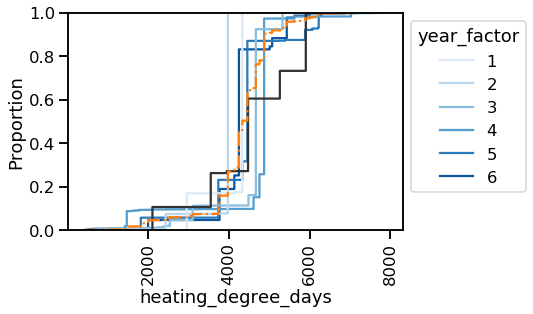

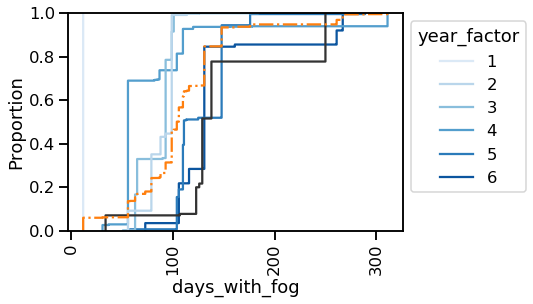

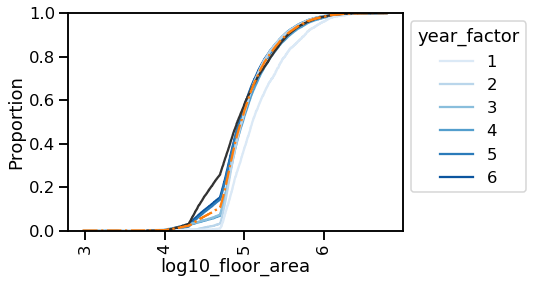

<IPython.core.display.Javascript object>

In [223]:
# Visualize CDFs
for col in [
    "state_factor",
    "building_class",
    "facility_type",
    "facility_type_parsed",
    "year_built",
    "energy_star_rating",
    "elevation",
    "january_avg_temp",
    "april_avg_temp",
    "august_avg_temp",
    "november_avg_temp",
    "cooling_degree_days",
    "heating_degree_days",
    "days_with_fog",
    "log10_floor_area",
]:
    plt.figure()
    ax = sns.ecdfplot(
        data=train_df.astype({"year_factor": str}),
        x=col,
        hue="year_factor",
        palette="Blues",
    )
    ax.tick_params(axis="x", labelrotation=90)
    sns.ecdfplot(
        data=test_df.astype({"year_factor": str}), x=col, color="0.2", ls="-", ax=ax
    )
    sns.ecdfplot(
        data=train_df.astype({"year_factor": str}), x=col, color="C1", ls="-.", ax=ax
    )
    sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))

In [226]:
def get_cat_to_numeric_dict(df, catcol):
    return dict(zip(df[col].dropna().unique(), np.arange(df[col].dropna().nunique())))


def get_critical_d(c, n1, n2):
    # Find c using table: https://sparky.rice.edu//astr360/kstest.pdf
    # for significance level alpha = 0.001, c = 1.93
    # for alpha = 0.01, c = 1.63
    return c * np.sqrt((n1 + n2) / (n1 * n2))


def get_values(df, col):
    if np.issubdtype(all_df[col].dtype, np.number):
        return df[col].dropna().values
    else:
        cat_to_numeric_dict = get_cat_to_numeric_dict(all_df, col)
        return df[col].dropna().map(cat_to_numeric_dict).values


# null hypothesis = two samples from same distribution
# Small ks value or large p-value --> accept / cannot reject null hypothesis --> likely same distribution
# Large ks value and small p-value --> reject null hypothesis --> likely different distributions

ks_df = pd.DataFrame()
for col in [
    "state_factor",
    "building_class",
    "facility_type",
    "facility_type_parsed",
    "year_built",
    "energy_star_rating",
    "elevation",
    "january_avg_temp",
    "february_avg_temp",
    "march_avg_temp",
    "april_avg_temp",
    "may_avg_temp",
    "june_avg_temp",
    "july_avg_temp",
    "august_avg_temp",
    "september_avg_temp",
    "october_avg_temp",
    "november_avg_temp",
    "december_avg_temp",
    "cooling_degree_days",
    "heating_degree_days",
    "precipitation_inches",
    "snowfall_inches",
    "snowdepth_inches",
    "days_below_30f",
    "days_below_20f",
    "days_below_10f",
    "days_below_0f",
    "days_above_80f",
    "days_above_90f",
    "days_above_100f",
    "days_above_110f",
    "direction_max_wind_speed",
    "direction_peak_wind_speed",
    "max_wind_speed",
    "days_with_fog",
    "log10_floor_area",
]:
    _test = get_values(test_df, col)
    _train = get_values(train_df, col)
    _train_by_year_dict = {}
    _ks_by_year_df = pd.DataFrame()
    for year in train_df["year_factor"].unique():
        _train_by_year_dict[year] = get_values(
            train_df.query("year_factor == @year"), col
        )
        _ks_by_year_df.loc[year, "ks_statistic"] = stats.ks_2samp(
            _train_by_year_dict[year], _test
        ).statistic
        _ks_by_year_df.loc[year, "critical_value"] = get_critical_d(
            1.95, len(_train_by_year_dict[year]), len(_test)
        )
        _ks_by_year_df.loc[year, "count"] = len(_train_by_year_dict[year])
    _ks_by_year_df.loc["all", "ks_statistic"] = stats.ks_2samp(_train, _test).statistic
    _ks_by_year_df.loc["all", "critical_value"] = get_critical_d(
        1.95, len(_train), len(_test)
    )
    _ks_by_year_df.loc["all", "count"] = len(_train)
    ks_df = pd.concat(
        [
            ks_df,
            _ks_by_year_df.reset_index()
            .rename(columns={"index": "year"})
            .assign(feature=col),
        ]
    )

<IPython.core.display.Javascript object>

In [227]:
ks_df = ks_df.reset_index(drop=True)

<IPython.core.display.Javascript object>

<Figure size 720x432 with 0 Axes>

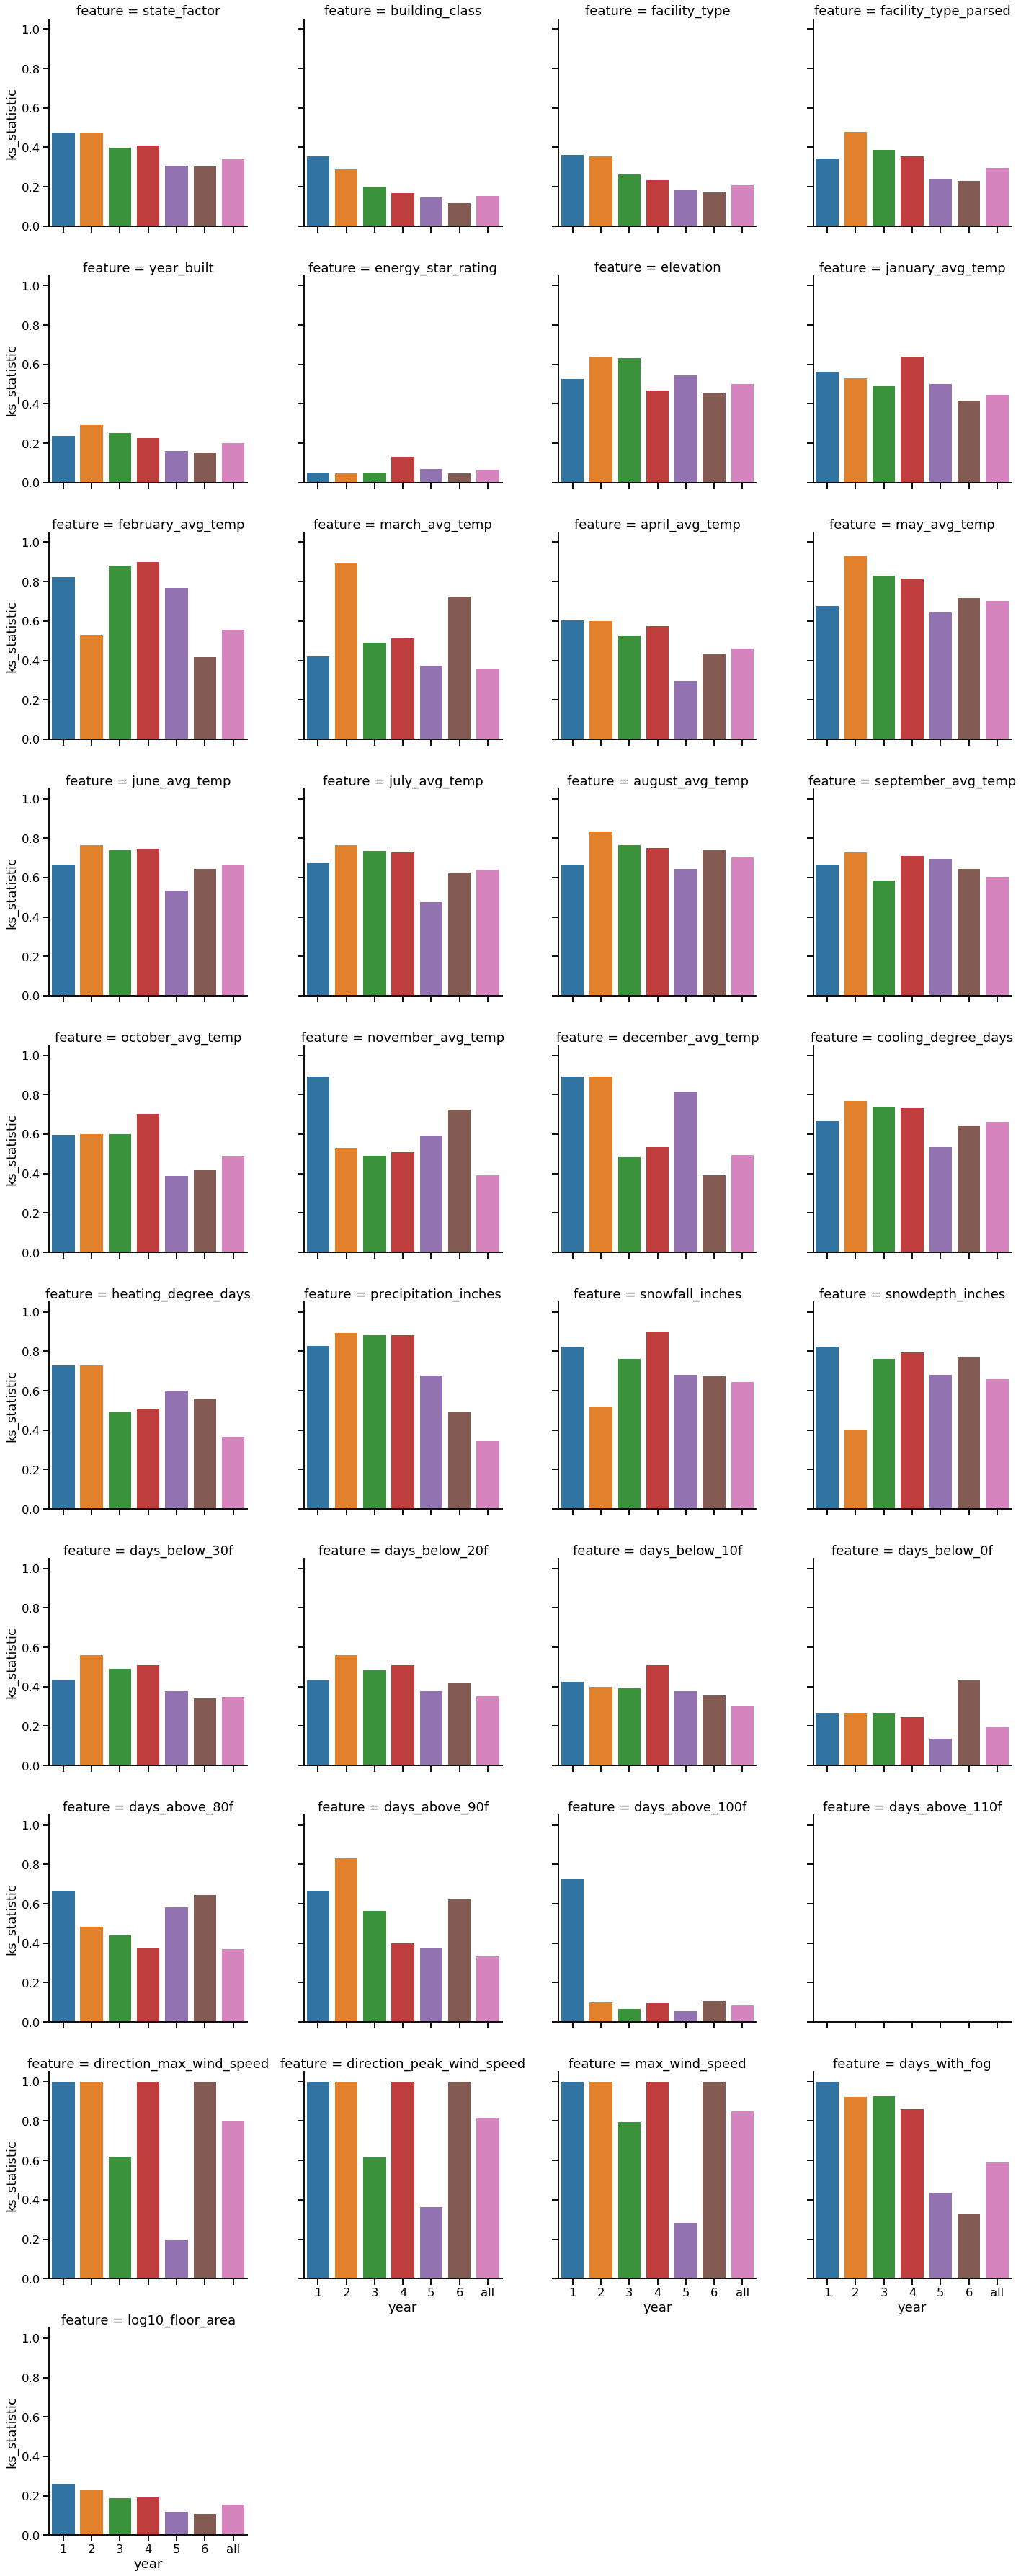

<IPython.core.display.Javascript object>

In [228]:
# Plot ks-statistic for each column across years
# In most cases, large ks-statistic indicates test 
# distribution differs from by year training distribution
# In particular, columns related to building itself 
# (state factor, building class, facility type, floor area)
# indicate years 1 and 2 are most different from test 
# distribution. Weather/environmental related columns 
# the top different years vary
plt.figure(figsize=(10, 6))
sns.catplot(data=ks_df, x='year', y='ks_statistic', col='feature', col_wrap=4, kind="bar")

# Junk bits and bobs beyond this

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

feature_dict = {
    "base_cat": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": False,
        "backfill_dict": {},
    },
    "base_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot_impute": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {
            "energy_star_rating": ["state_factor", "building_class", "facility_type"]
        },
    },
    #     "log_temp_pca_cat": {
    #         "cols_to_reduce": temp_col_list,
    #         "log10_transform_cols": ["floor_area"],
    #         "if_one_hot": False,
    #         "backfill_dict": {},
    #     },
    #     "log_temp_precip_pca_onehot": {
    #         "cols_to_reduce": temp_col_list + inch_col_list,
    #         "log10_transform_cols": ["floor_area"],
    #         "if_one_hot": True,
    #         "backfill_dict": {},
    #     },
}

<IPython.core.display.Javascript object>

Fitting PCA with 9 components


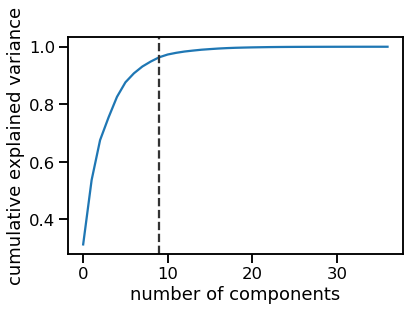

<IPython.core.display.Javascript object>

In [18]:
config_name = "log_temp_pca_onehot"
cols_to_reduce = feature_dict[config_name]["cols_to_reduce"]
log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
backfill_dict = feature_dict[config_name]["backfill_dict"]
if_scale = False
if_one_hot = feature_dict[config_name]["if_one_hot"]

train_filter_df, test_filter_df, pca_cols = process_data(
    train_df.drop_duplicates().copy(),
    test_df.drop_duplicates().copy(),
    cols_to_reduce,
    log10_transform_cols,
    0,
    backfill_dict,
)

In [19]:
train_df.head()

,year_factor,state_factor,building_class,facility_type,floor_area,year_built,energy_star_rating,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30f,days_below_20f,days_below_10f,days_below_0f,days_above_80f,days_above_90f,days_above_100f,days_above_110f,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


<IPython.core.display.Javascript object>

In [65]:
env_feature_cols = (
    temp_col_list
    + days_col_list
    + inch_col_list
    + wind_col_list
    + ["elevation", "year_factor", "state_num"]  # "state_factor"]
)

building_feature_cols = [
    "building_class_num",
    "facility_type",
    "log10_floor_area",
    "year_built",
]

energy_related_cols = ["energy_star_rating", "site_eui"]

<IPython.core.display.Javascript object>

In [66]:
train_df["facility_type_parsed_num"] = train_df["facility_type_parsed"].map(
    dict(
        zip(
            train_df["facility_type_parsed"].unique(),
            np.arange(train_df["facility_type_parsed"].nunique()),
        )
    )
)
train_df["state_num"] = train_df["state_factor"].str.replace("State_", "").astype(int)
train_df["building_class_num"] = train_df["building_class"].map(
    {"Residential": 0, "Commercial": 1}
)

<IPython.core.display.Javascript object>

In [77]:
n_neighbors = 3
random_state = 0
train_filter_df = train_df.dropna().reset_index(drop=True)
# Load Digits dataset
X, y = (
    train_filter_df[
        env_feature_cols
        + ["building_class_num", "floor_area", "year_built", "energy_star_rating"]
    ].copy(),
    train_filter_df["facility_type_parsed_num"].copy(),
)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)

dim = X.shape[1]
n_classes = len(np.unique(y))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

<IPython.core.display.Javascript object>

In [83]:
current_model = lda.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [85]:
lda.score(X_test, y_test)

0.21839080459770116

<IPython.core.display.Javascript object>

In [46]:
word_stems = [
    "unit_building",
    "education",
    "food",
    "grocery",
    "health_care",
    "lodging",
    "mixed_use",
    "multifamily",
    "office",
    "public_assembly",
    "public_safety",
    "religious",
    "retail",
    "service",
    "warehouse",
]
unique_facilities = train_df["facility_type"].str.lower().drop_duplicates()
parsed_facility_dict = {
    k: unique_facilities[unique_facilities.str.contains(k)].tolist() for k in word_stems
}
parsed_facility_dict

{'unit_building': ['5plus_unit_building', '2to4_unit_building'],
 'education': ['education_other_classroom',
  'education_college_or_university',
  'education_uncategorized',
  'education_preschool_or_daycare'],
 'food': ['grocery_store_or_food_market',
  'food_service_uncategorized',
  'food_service_other',
  'food_service_restaurant_or_cafeteria',
  'food_sales'],
 'grocery': ['grocery_store_or_food_market'],
 'health_care': ['health_care_inpatient',
  'health_care_uncategorized',
  'health_care_outpatient_clinic',
  'health_care_outpatient_uncategorized'],
 'lodging': ['lodging_hotel',
  'lodging_dormitory_or_fraternity_sorority',
  'lodging_other',
  'lodging_uncategorized'],
 'mixed_use': ['mixed_use_predominantly_commercial',
  'mixed_use_commercial_and_residential',
  'office_mixed_use',
  'mixed_use_predominantly_residential'],
 'multifamily': ['multifamily_uncategorized'],
 'office': ['office_uncategorized',
  'office_medical_non_diagnostic',
  'office_bank_or_other_financial'

<IPython.core.display.Javascript object>

In [41]:
train_df.dropna(subset=["energy_star_rating"]).groupby("facility_type")[
    "floor_area"
].count()

facility_type
2to4_Unit_Building                            1644
5plus_Unit_Building                           1053
Commercial_Other                               256
Commercial_Unknown                              22
Data_Center                                      9
Education_College_or_university                 65
Education_Other_classroom                     3705
Education_Uncategorized                          7
Food_Sales                                      59
Grocery_store_or_food_market                   405
Health_Care_Inpatient                          349
Health_Care_Outpatient_Clinic                    6
Health_Care_Outpatient_Uncategorized             6
Industrial                                      43
Laboratory                                       2
Lodging_Dormitory_or_fraternity_sorority       564
Lodging_Hotel                                 1994
Mixed_Use_Commercial_and_Residential           168
Mixed_Use_Predominantly_Commercial              39
Mixed_Use_Predomi

<IPython.core.display.Javascript object>

In [38]:
train_df = parse_facility_type(train_df)
train_df["log10_floor_area"] = np.log10(train_df["floor_area"])
train_df.head()

,year_factor,state_factor,building_class,facility_type,floor_area,year_built,energy_star_rating,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30f,days_below_20f,days_below_10f,days_below_0f,days_above_80f,days_above_90f,days_above_100f,days_above_110f,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,facility_type_parsed,log10_floor_area
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,Grocery,4.787049
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,Warehouse,5.437751
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,Retail,5.447197
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,Education,4.742921
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,Warehouse,4.819544


<IPython.core.display.Javascript object>

In [100]:
train_df.columns

Index(['year_factor', 'state_factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'elevation',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

<IPython.core.display.Javascript object>

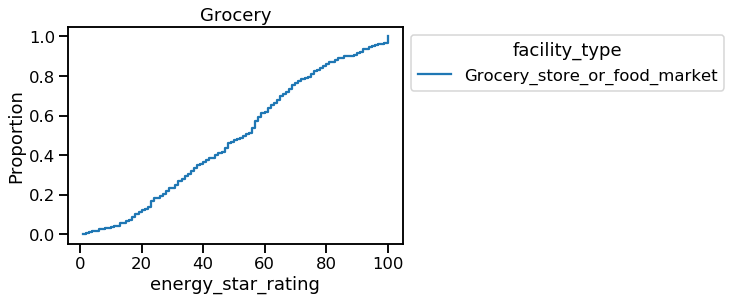

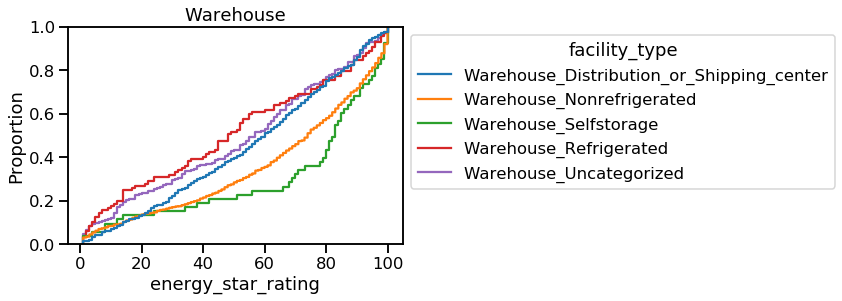

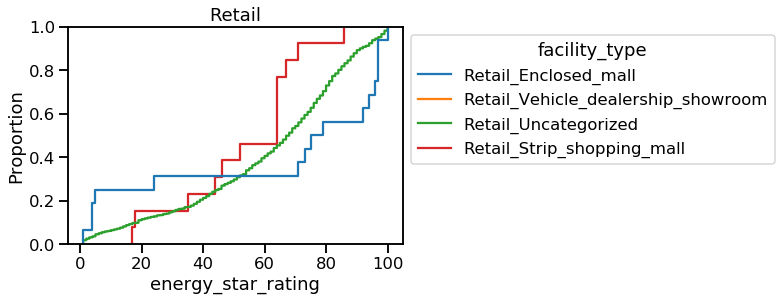

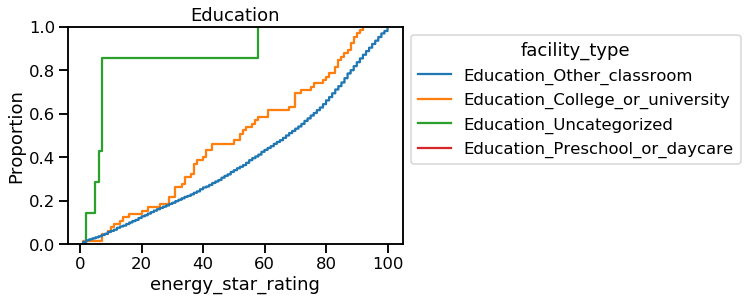

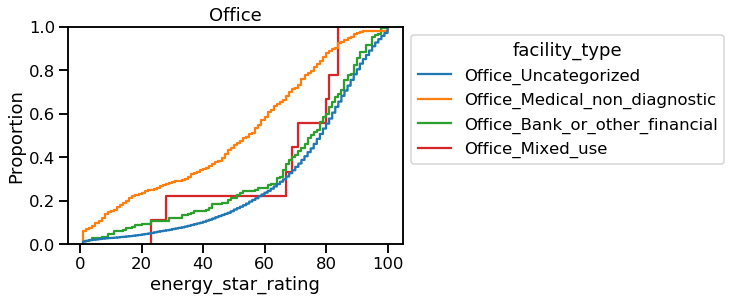

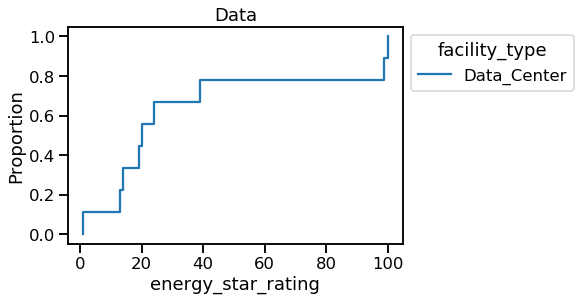

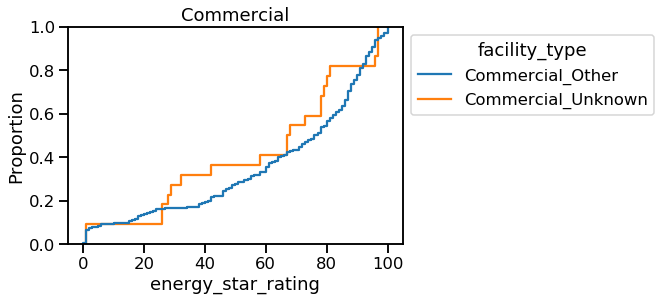

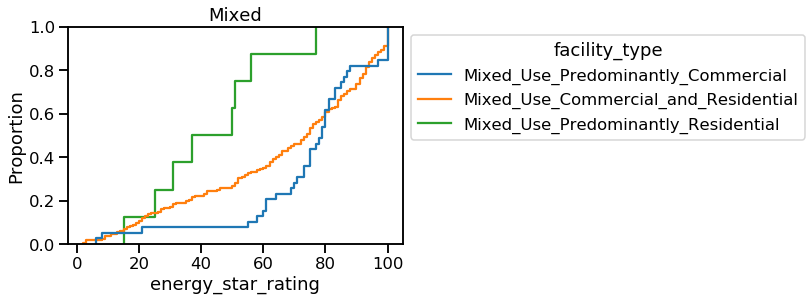

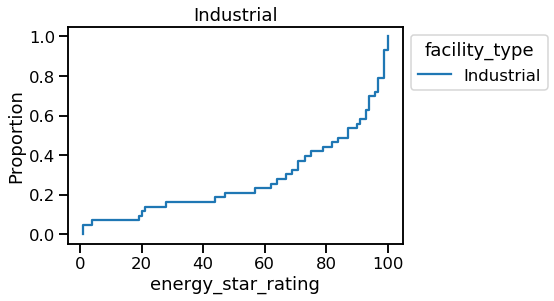

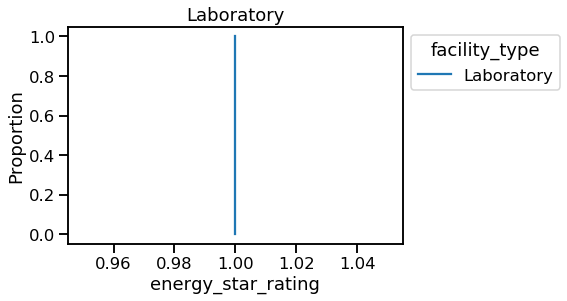

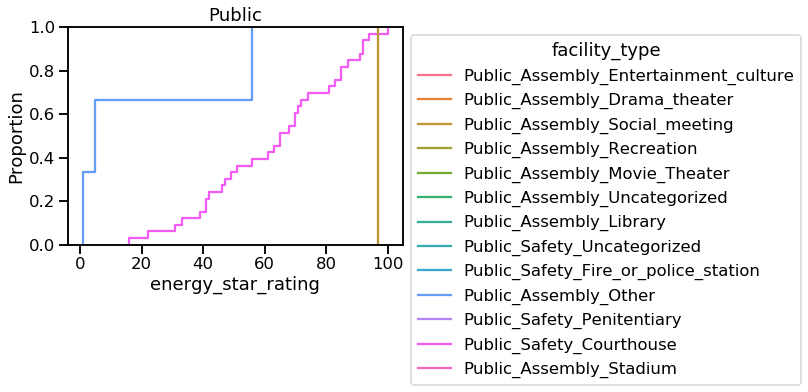

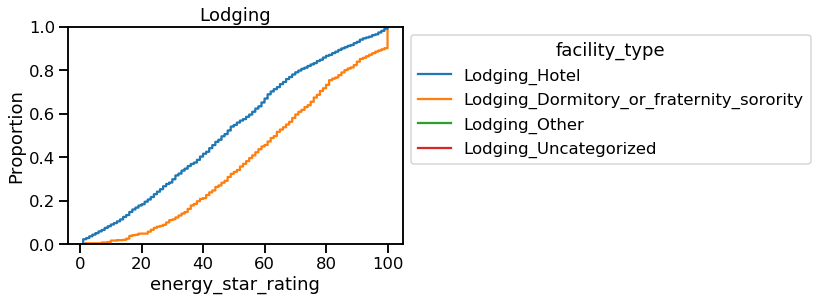

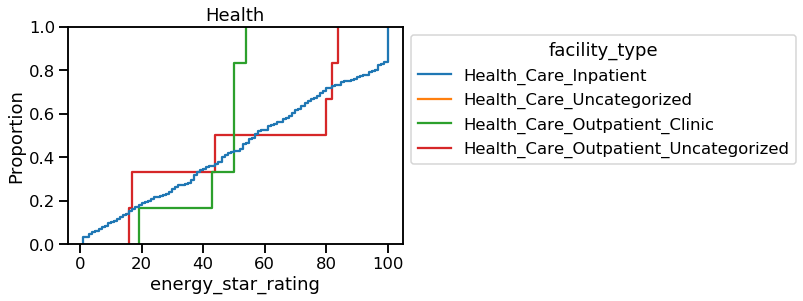

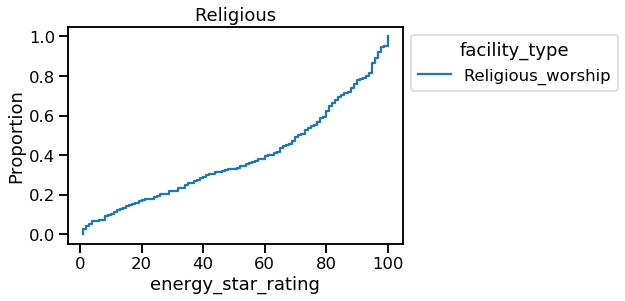

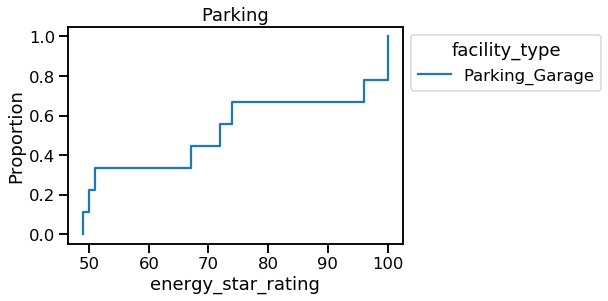

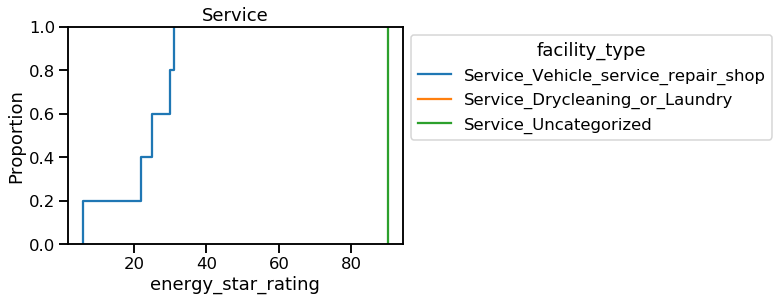

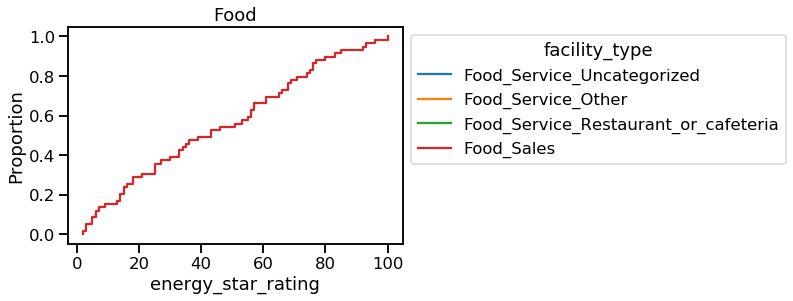

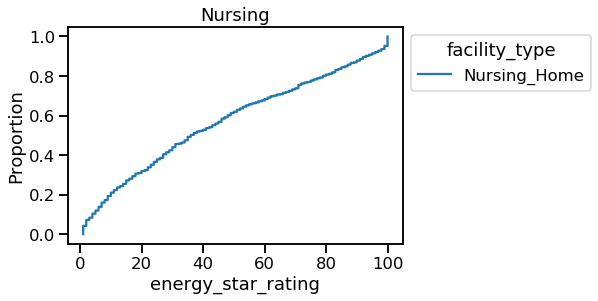

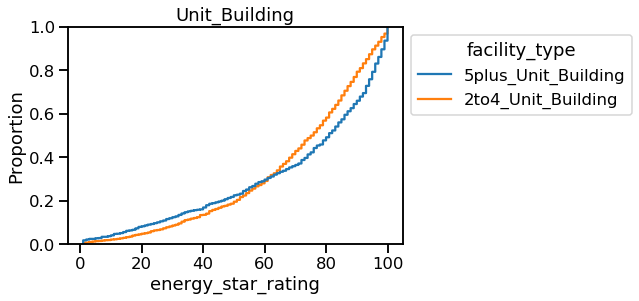

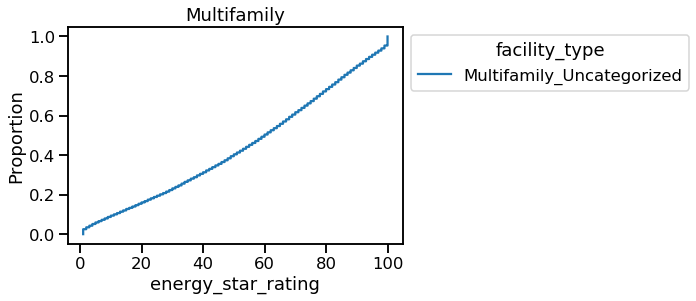

<IPython.core.display.Javascript object>

In [99]:
for parsed_facil in train_df["facility_type_parsed"].unique():
    plt.figure()
    ax = sns.ecdfplot(
        data=train_df.query("facility_type_parsed == @parsed_facil"),
        x="energy_star_rating",
        hue="facility_type",
    )
    plt.title(parsed_facil)
    sns.move_legend(ax, bbox_to_anchor=(1, 1), loc="upper left")